# Modeling spectral bands with `climlab`

Here is a brief introduction to the `climlab.BandRCModel` process.

This is a model that divides the spectrum into 7 distinct bands: three shortwave and four longwave.

As we will see, the process works much like the familiar `climlab.RadiativeConvectiveModel`.


## About the spectra

The shortwave is divided into three channels:

- Channel 0 is the Hartley and Huggins band (extreme UV, 200 - 340 nm, 1% of total flux, strong ozone absorption)
- Channel 1 is Chappuis band (450 - 800 nm, 27% of total flux, moderate ozone absorption)
- Channel 2 is remaining radiation (72% of total flux, largely in the visible range, no ozone absorption)

The longwave is divided into four bands:

- Band 0 is the window region (between 8.5 and 11 $\mu$m), 17% of total flux.
- Band 1 is the CO2 absorption channel (the band of strong absorption by CO2 around 15 $\mu$m), 15% of total flux
- Band 2 is a weak water vapor absorption channel, 35% of total flux
- Band 3 is a strong water vapor absorption channel, 33% of total flux

The longwave decomposition is not as easily related to specific wavelengths, as in reality there is a lot of overlap between H$_2$O and CO$_2$ absorption features (as well as absorption by other greenhouse gases such as CH$_4$ and N$_2$O that we are not representing).

### Example usage of the spectral model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as const

First try a model with all default parameters. Usage is very similar to the familiar `RadiativeConvectiveModel`.

In [2]:
col1 = climlab.BandRCModel()
print col1

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  q: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



Check out the list of subprocesses.

We now have a process called `H2O`, in addition to things we've seen before.

This model keeps track of water vapor. We see the specific humidity in the list of state variables:

In [3]:
col1.state

{'Tatm': Field([ 278.        ,  275.31034483,  272.62068966,  269.93103448,
         267.24137931,  264.55172414,  261.86206897,  259.17241379,
         256.48275862,  253.79310345,  251.10344828,  248.4137931 ,
         245.72413793,  243.03448276,  240.34482759,  237.65517241,
         234.96551724,  232.27586207,  229.5862069 ,  226.89655172,
         224.20689655,  221.51724138,  218.82758621,  216.13793103,
         213.44827586,  210.75862069,  208.06896552,  205.37931034,
         202.68965517,  200.        ]),
 'Ts': Field([ 288.]),
 'q': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.])}

The water vapor field is initialized to zero. The `H2O` process will set the specific humidity field at every timestep to a specified profile. More on that below. For now, let's compute a radiative equilibrium state.

In [4]:
col1.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.99867375676 years.


In [5]:
# Check for energy balance
col1.diagnostics['ASR'] - col1.diagnostics['OLR']

Field([-0.00048388])

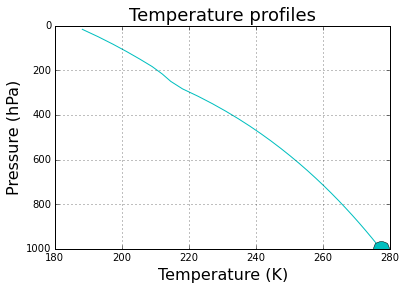

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( col1.Tatm, col1.lev, 'c-', label='default' )
ax.plot( col1.Ts, climlab.constants.ps, 'co', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Temperature profiles', fontsize = 18)
ax.grid()

By default this model has convective adjustment.  We can set the adjusted lapse rate by passing a parameter when we create the model.

The model currently has no ozone (so there is no stratosphere). Not very realistic!


More reasonable-looking troposphere, but still no stratosphere.

### About the radiatively active gases

The Band model is aware of three different absorbing gases: O3 (ozone), CO2, and H2O (water vapor). The abundances of these gases are stored in a dictionary of arrays as follows:

In [7]:
col1.absorber_vmr

{'CO2': Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038]),
 'H2O': Field([  3.69869819e-03,   3.24955218e-03,   2.83854045e-03,
          2.46407430e-03,   2.12453253e-03,   1.81826254e-03,
          1.54358168e-03,   1.29877911e-03,   1.08211801e-03,
          8.91838347e-04,   7.26160241e-04,   5.83288081e-04,
          4.61415435e-04,   3.58730942e-04,   2.73425330e-04,
          2.03699731e-04,   1.47775487e-04,   1.03905677e-04,
          7.03885645e-05,   4.55832116e-05,   2.79274158e-05,
          1.59580759e-05,   1.02718614e-05,   7.31276075e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06]),
 'O3': Field([ 0.,  0.

Ozone and CO2 are both specified in the model. The default, as you see above, is zero ozone, and constant (well-mixed) CO2 at a volume mixing ratio of 3.8E-4 or 380 ppm.

Water vapor is handled differently: it is determined by the model at each timestep. We make the following assumptions, following a classic paper on radiative-convective equilibrium by Manabe and Wetherald (J. Atmos. Sci. 1967):

- the relative humidity just above the surface is fixed at 77% (can be changed of course... see the parameter `col1.relative_humidity`
- water vapor drops off linearly with pressure
- there is a small specified amount of water vapor in the stratosphere.

## Putting in some ozone

We need to provide some ozone data to the model in order to simulate a stratosphere. As we did with the original column model, we will use the ozone climatology data provided with the CESM model.

See here for more information, including some plots of the ozone data:
<http://www.atmos.albany.edu/facstaff/brose/classes/ENV480_Spring2014/styled-5/code-3/index.html>

In [8]:
import netCDF4 as nc

datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )
ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )

In [9]:
#  Dimensions of the ozone file
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]

In [10]:
# Taking annual, zonal, and global averages of the ozone data
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )
O3_global = np.sum( O3_zon * np.cos(np.deg2rad(lat)), axis=1 ) / sum( np.cos(np.deg2rad(lat) ) )

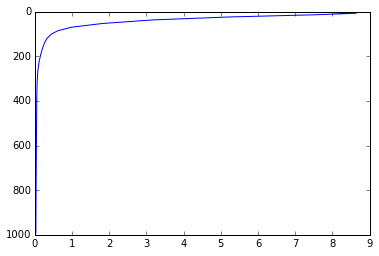

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( O3_global*1E6, lev)
ax.invert_yaxis()

We are going to create another instance of the model, this time using the same vertical coordinates as the ozone data.

In [12]:
#  Create the column with appropriate vertical coordinate, surface albedo and convective adjustment
col2 = climlab.BandRCModel(lev=lev)
print col2

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  q: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>



In [13]:
#  Set the ozone mixing ratio
#   IMPORTANT: we need to flip the ozone array around because the vertical coordinate runs the wrong way
#   (first element is top of atmosphere, whereas our model expects the first element to be just above the surface)
col2.absorber_vmr['O3'] = np.flipud(O3_global)

In [14]:
#  Run the model out to equilibrium!
col2.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


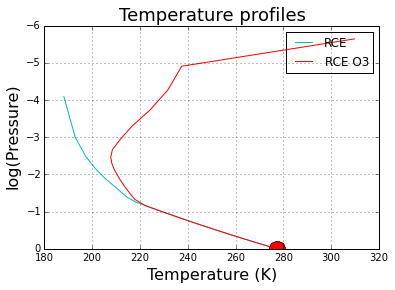

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot( col1.Tatm, np.log(col1.lev/1000), 'c-', label='RCE' )
ax.plot( col1.Ts, 0, 'co', markersize=16 )
ax.plot(col2.Tatm, np.log(col2.lev/1000), 'r-', label='RCE O3' )
ax.plot(col2.Ts, 0, 'ro', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('log(Pressure)', fontsize=16 )
ax.set_title('Temperature profiles', fontsize = 18)
ax.grid()
ax.legend()

Once we include ozone we get a well-defined stratosphere. We can also a slight cooling effect in the troposphere.

Things to consider / try:

- Here we used the global annual mean Q = 341.3 W m$^{-2}$. We might want to consider latitudinal or seasonal variations in Q.
- We also used the global annual mean ozone profile! Ozone varies tremendously in latitude and by season. That information is all contained in the ozone data file we opened above. We might explore the effects of those variations.
- We can calculate climate sensitivity in this model by doubling the CO2 concentration and re-running out to the new equilibrium. Does the amount of ozone affect the climate sensitivity?  (example below)
- An important shortcoming of the model: there are no clouds! (that would be the next step in the hierarchy of column models)
- Clouds would act both in the shortwave (increasing the albedo, cooling the climate) and in the longwave (greenhouse effect, warming the climate). Which effect is stronger depends on the vertical structure of the clouds (high or low clouds) and their optical properties (e.g. thin cirrus clouds are nearly transparent to solar radiation but are good longwave absorbers).

In [16]:
col3 = climlab.process_like(col2)
print col3

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  q: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [17]:
# Let's double CO2.
col3.absorber_vmr['CO2'] *= 2.

In [18]:
col3.compute_diagnostics()
print 'The radiative forcing for doubling CO2 is %f W/m2.' % (col2.diagnostics['OLR'] - col3.diagnostics['OLR'])

The radiative forcing for doubling CO2 is 1.532071 W/m2.


In [19]:
col3.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 5.00489811966 years.


In [20]:
col3.diagnostics['ASR'] - col3.diagnostics['OLR']

Field([  2.81633277e-05])

In [21]:
print 'The Equilibrium Climate Sensitivity is %f K.' % (col3.Ts - col2.Ts)

The Equilibrium Climate Sensitivity is 3.444973 K.


In [22]:
col4 = climlab.process_like(col1)
print col4

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  q: (30,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   surface: <class 'climlab.surface.surface_radiation.SurfaceRadiation'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [23]:
col4.absorber_vmr

{'CO2': Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038]),
 'H2O': Field([  3.69869819e-03,   3.24955218e-03,   2.83854045e-03,
          2.46407430e-03,   2.12453253e-03,   1.81826254e-03,
          1.54358168e-03,   1.29877911e-03,   1.08211801e-03,
          8.91838347e-04,   7.26160241e-04,   5.83288081e-04,
          4.61415435e-04,   3.58730942e-04,   2.73425330e-04,
          2.03699731e-04,   1.47775487e-04,   1.03905677e-04,
          7.03885645e-05,   4.55832116e-05,   2.79274158e-05,
          1.59580759e-05,   1.02718614e-05,   7.31276075e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06]),
 'O3': Field([ 0.,  0.

In [24]:
col4.absorber_vmr['CO2'] *= 2.
col4.compute_diagnostics()
print 'The radiative forcing for doubling CO2 is %f W/m2.' % (col1.diagnostics['OLR'] - col4.diagnostics['OLR'])

The radiative forcing for doubling CO2 is 4.552774 W/m2.


In [25]:
col4.integrate_years(3.)
col4.diagnostics['ASR'] - col4.diagnostics['OLR']

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 5.00489811966 years.


Field([  4.48464817e-05])

In [26]:
print 'The Equilibrium Climate Sensitivity is %f K.' % (col4.Ts - col1.Ts)

The Equilibrium Climate Sensitivity is 3.984387 K.


Interesting that the model is MORE sensitive when ozone is set to zero.